In [26]:
# -*- coding: utf-8 -*-

# pandas
import pandas as pd

# numpy, matplotlb, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy.stats as st

In [27]:
# Import Dataset
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

df = train_df.append(test_df, ignore_index=True) # train = df[:1460], test = df[1460:]
df = df.drop('Id', axis=1)

## Baseline Model
A baseline model against to our feature engineering results.

### Preprocess

In [28]:
def preScoreTest(df):
    train = df[:1460]
    test = df[1460:]
    
    train = pd.get_dummies(train)
    train = train.fillna(train.median())
    
    test = pd.get_dummies(test)
    test = test.fillna(test.median())
    
    common_cols = list(set(train.columns.tolist()) & set(test.columns.tolist()))
    test = test[common_cols]
    test = test.drop('SalePrice', axis=1)
    train = train[common_cols]
    
    X_train = train.drop('SalePrice', axis=1)
    y_train = train['SalePrice']
    X_test = test
    return X_train, y_train, X_test

In [29]:
X_train, y_train, X_test = preScoreTest(df)

### Modelling

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold

In [31]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [32]:
print('RMSE:', rmsle_cv(rfg).mean())

RMSE: 29992.3367571


### Data Type Transformation
* Numeric to Categoric  
* Rank Fields to Numeric  

In [34]:
df['MSSubClass'] = df['MSSubClass'].astype('object')

In [35]:
df.BsmtCond =  df.BsmtCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.BsmtExposure = df.BsmtExposure.map({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df.BsmtFinType1 = df.BsmtFinType1.map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df.BsmtFinType2 = df.BsmtFinType2.map({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df.BsmtQual = df.BsmtQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df.ExterCond = df.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.ExterQual = df.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df.FireplaceQu = df.FireplaceQu.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df.GarageCond = df.GarageCond.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.GarageQual = df.GarageQual.map({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

df.HeatingQC = df.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.KitchenQual = df.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df.PoolQC = df.PoolQC.map({'NA':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

In [38]:
X_train, y_train, test = preScoreTest(df)
print('RMSE:', rmsle_cv(rfg).mean())

RMSE: 29665.8389175


### Imputation

In [39]:
# Missing data in train set
def missing_data(df):
    missing = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([missing, percent], axis=1, keys=['Missing', 'Percent'])
    return missing_data
missing = missing_data(df)
print(missing.head(35))

              Missing   Percent
PoolQC           2909  0.996574
MiscFeature      2814  0.964029
Alley            2721  0.932169
Fence            2348  0.804385
SalePrice        1459  0.499829
FireplaceQu      1420  0.486468
LotFrontage       486  0.166495
GarageQual        159  0.054471
GarageYrBlt       159  0.054471
GarageFinish      159  0.054471
GarageCond        159  0.054471
GarageType        157  0.053786
BsmtCond           82  0.028092
BsmtExposure       82  0.028092
BsmtQual           81  0.027749
BsmtFinType2       80  0.027407
BsmtFinType1       79  0.027064
MasVnrType         24  0.008222
MasVnrArea         23  0.007879
MSZoning            4  0.001370
BsmtHalfBath        2  0.000685
Utilities           2  0.000685
Functional          2  0.000685
BsmtFullBath        2  0.000685
Electrical          1  0.000343
Exterior2nd         1  0.000343
KitchenQual         1  0.000343
GarageCars          1  0.000343
Exterior1st         1  0.000343
GarageArea          1  0.000343
TotalBsm

* PoolQC, MiscFeature, Alley, Fence, FireplaceQu, GarageX, BsmtX都是由於沒有(no Pool ,Miss Feature, Alley ...)，而非真的遺失因此填上"No"值。
* 利用其他欄位預測LotFrontage的遺失值
* 其餘遺失值都很低(<0.3%)，因此帶入最常見的數值

In [40]:
df_m = df.copy()

In [41]:
df_m['PoolQC'].fillna('No', inplace=True)
df_m['Alley'].fillna('No', inplace=True)
df_m['MiscFeature'].fillna('No', inplace=True)
df_m['Fence'].fillna('No', inplace=True)
df_m['FireplaceQu'].fillna('No', inplace=True)

df_m['Fence'].fillna('No', inplace=True)

df_m['GarageFinish'].fillna('No', inplace=True)
df_m['GarageType'].fillna('No', inplace=True)
df_m['GarageYrBlt'].fillna(0, inplace=True) 
df_m['GarageCond'].fillna(0, inplace=True)
df_m['GarageQual'].fillna(0, inplace=True)
df_m['GarageCars'].fillna(0, inplace=True)
df_m['GarageArea'].fillna(0, inplace=True)

df_m['BsmtFinType2'].fillna(0, inplace=True)
df_m['BsmtExposure'].fillna(0, inplace=True)
df_m['BsmtFinType1'].fillna(0, inplace=True)
df_m['BsmtQual'].fillna(0, inplace=True)
df_m['BsmtCond'].fillna(0, inplace=True)
df_m['BsmtHalfBath'].fillna(0, inplace=True)
df_m['BsmtFullBath'].fillna(0, inplace=True)
df_m['BsmtFinSF1'].fillna(0, inplace=True)
df_m['BsmtFinSF2'].fillna(0, inplace=True)
df_m['TotalBsmtSF'].fillna(0, inplace=True)
df_m['BsmtUnfSF'].fillna(0, inplace=True)

df_m['MasVnrArea'].fillna(0, inplace=True)
df_m['MasVnrType'].fillna('No', inplace=True)

df_m['Electrical'].fillna('SBrkr', inplace=True)
df_m['MSZoning'].fillna('RL', inplace=True)
df_m['Functional'].fillna('Typ', inplace=True)
df_m['SaleType'].fillna('WD', inplace=True)
df_m['KitchenQual'].fillna(3, inplace=True)
df_m['Exterior1st'].fillna('VinylSd', inplace=True)
df_m['Exterior2nd'].fillna('VinylSd', inplace=True)

df_m = df_m.drop('Utilities', axis=1)

In [42]:
# Using xgboost to impute missing LotFrontage
from xgboost import XGBRegressor

null_idx = df_m.loc[df_m['LotFrontage'].isnull()].index

df_lot = df_m.copy()
df_lot = pd.get_dummies(df_lot)
train_lot = df_lot.drop(df_lot.index[[null_idx]])
test_lot = df_lot.loc[null_idx]

test_lot.shape, train_lot.shape

xgb = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
xgb.fit(train_lot.drop(['LotFrontage', 'SalePrice'], axis=1), train_lot['LotFrontage'])
pred_lot = xgb.predict(test_lot.drop(['LotFrontage', 'SalePrice'], axis=1))
df_m.loc[null_idx, 'LotFrontage'] = pred_lot

/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
missing = missing_data(df_m)
print(missing.head(5))

            Missing   Percent
SalePrice      1459  0.499829
YrSold            0  0.000000
Foundation        0  0.000000
ExterCond         0  0.000000
ExterQual         0  0.000000


SalePrice missing at test.csv

In [45]:
X_train, y_train, test = preScoreTest(df_m)
rfg = RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1)
print('RMSE:', rmsle_cv(rfg).mean())

RMSE: 30007.2942929


錯誤在填補完後增加，是因為在做預處理的時候，若是遇見類別變數的遺失值會自動捨棄該欄位，因此推測我們填入的欄位有些是非常多餘的，應該發生在有大量遺失值的特徵中。

## XGBoost!

試試看其他算法！

In [16]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
accuracies = cross_val_score(estimator = xgb, X = train.drop('SalePrice', axis=1), y = train['SalePrice'], cv = 5, n_jobs=-1)
print('CV score is:', accuracies.mean())

CV score is: 0.900381587171


In [46]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.05,n_estimators=500,max_depth=3,colsample_bytree=0.4)
print('RMSE:', rmsle_cv(xgb).mean())

RMSE: 25204.7647456


## Create / Discard Features

In [47]:
df_f = df_m.copy()

In [48]:
# Too much duplicate value in single column
dup = [n for n in df_f.columns if df_f[n].value_counts().max()/len(df_f) > 0.97]
print(dup)

['3SsnPorch', 'Condition2', 'Heating', 'LowQualFinSF', 'PoolArea', 'PoolQC', 'RoofMatl', 'Street']


In [49]:
df_f = df_f.drop(dup, axis=1)

In [50]:
# Total sq
df_f['TotalSF'] = df_f['TotalBsmtSF'] + df_f['1stFlrSF'] + df_f['2ndFlrSF']

In [51]:
# Bath
df_f['Bath'] = df_f['FullBath'] + 0.5 * df_f['HalfBath'] + df_f['BsmtFullBath'] + 0.5 * df_f['BsmtHalfBath']
df_f = df_f.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], axis=1)

In [55]:
X_train, y_train, test = preScoreTest(df_f)
print('RMSE:', rmsle_cv(xgb).mean())

RMSE: 24311.5179369


## Normality

In [56]:
df_normal = df_f.copy()

In [57]:
# skewness of features
numeric_cols = [f for f in df_normal if df_normal.dtypes[f] != 'object']
df_normal[numeric_cols].skew()

1stFlrSF          1.470360
2ndFlrSF          0.862118
BedroomAbvGr      0.326492
BsmtCond         -3.605964
BsmtExposure      1.117303
BsmtFinSF1        1.425963
BsmtFinSF2        4.148275
BsmtFinType1     -0.149621
BsmtFinType2      3.153959
BsmtQual         -1.269195
BsmtUnfSF         0.919812
EnclosedPorch     4.005950
ExterCond         1.316590
ExterQual         0.786786
Fireplaces        0.733872
GarageArea        0.239380
GarageCars       -0.219694
GarageCond       -3.384860
GarageQual       -3.265354
GarageYrBlt      -3.908213
GrLivArea         1.270010
HeatingQC        -0.550192
KitchenAbvGr      4.304467
KitchenQual       0.438761
LotArea          12.829025
LotFrontage       1.315325
MasVnrArea        2.614936
MiscVal          21.958480
MoSold            0.195985
OpenPorchSF       2.536417
OverallCond       0.570605
OverallQual       0.197212
SalePrice         1.882876
ScreenPorch       3.948723
TotRmsAbvGrd      0.758757
TotalBsmtSF       1.157489
WoodDeckSF        1.843380
Y

In [58]:
skew =df_normal[numeric_cols].columns[df_normal[numeric_cols].skew() > 0.75]
skew

Index(['1stFlrSF', '2ndFlrSF', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType2', 'BsmtUnfSF', 'EnclosedPorch', 'ExterCond', 'ExterQual',
       'GrLivArea', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'MasVnrArea',
       'MiscVal', 'OpenPorchSF', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'WoodDeckSF', 'TotalSF'],
      dtype='object')

In [59]:
for i in skew.values:
    df_normal[i] = np.log1p(df_normal[i])

In [62]:
X_train, y_train, test = preScoreTest(df_normal)
print('RMSE:', np.expm1(rmsle_cv(xgb).mean()))

RMSE: 0.125934036339


### Outlier Detection

In [121]:
df_out = df_normal.copy()
X_train, y_train, X_test = preScoreTest(df_out)

In [30]:
import statsmodels.api as sm

regressor = sm.OLS(train['SalePrice'], train.drop('SalePrice', axis=1)).fit()
result = regressor.outlier_test()

/home/lafes/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:309: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/home/lafes/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/lafes/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/lafes/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/lafes/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:147: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals <= alphacBonf
/home/lafes/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251

In [31]:
outlier = result['bonf(p)']
outlier = outlier[outlier<1e-3].index
print(outlier)

Int64Index([462, 523, 632, 968, 1298, 1324], dtype='int64')


In [122]:
outlier

[462, 523, 632, 968, 1298, 1324]

In [123]:
X_train = X_train.drop(outlier, axis=0)
y_train = y_train.drop(outlier, axis=0)

In [126]:
print('RMSE:', np.expm1(rmsle_cv(xgb).mean()))

RMSE: 0.111869052334


## Model Selection

In [147]:
from sklearn.linear_model import ElasticNet, Lasso, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

In [128]:
lasso = Lasso(alpha =0.001, random_state=1)
ENet = ElasticNet(alpha=0.001, l1_ratio=.9, random_state=3)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
xgb = XGBRegressor(colsample_bytree=0.2, learning_rate=0.05, max_depth=3, n_estimators=1200)
orth = OrthogonalMatchingPursuit()

In [135]:
def scoreTest(models):
    score = {}
    predict = {}
    for m in models:
        name = m.__class__.__name__
        mean = rmsle_cv(m).mean()
        score[name] = mean
        
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        
        predict[name] = y_pred
    score = pd.Series(score)
    predict = pd.DataFrame(predict)
    return score, predict

In [136]:
result, predict = scoreTest(models = [lasso ,ENet, GBoost, xgb, orth])

/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/lafes/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/linear_model/coordin

In [137]:
predict.corr()

,ElasticNet,GradientBoostingRegressor,Lasso,OrthogonalMatchingPursuit,XGBRegressor
ElasticNet,1.000000,0.985202,0.999970,0.989629,0.988900
GradientBoostingRegressor,0.985202,1.000000,0.985118,0.973310,0.991923
Lasso,0.999970,0.985118,1.000000,0.989499,0.988622
OrthogonalMatchingPursuit,0.989629,0.973310,0.989499,1.000000,0.980154
XGBRegressor,0.988900,0.991923,0.988622,0.980154,1.000000


In [138]:
result.sort_values()

XGBRegressor                 0.106042
ElasticNet                   0.106845
Lasso                        0.107447
GradientBoostingRegressor    0.109146
OrthogonalMatchingPursuit    0.119163
dtype: float64

In [139]:
y_pred = np.expm1(0.25*predict['ElasticNet'] + 0.2 * predict['GradientBoostingRegressor'] + 0.25*predict['Lasso'] + 0.3*predict['XGBRegressor'])

In [140]:
submission = pd.DataFrame({
    'Id':test_df['Id'],
    'SalePrice':y_pred
})
submission.to_csv('avg_ensemble2', index=False)

## Interpretation
ref:   
[Selecting Good Featuers](http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/)  
[Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models)

In [46]:
from sklearn.linear_model import Ridge

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 7, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

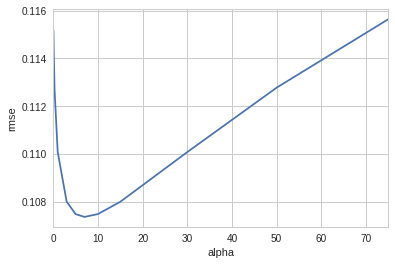

In [47]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

min at alpha=7 

In [49]:
model_ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

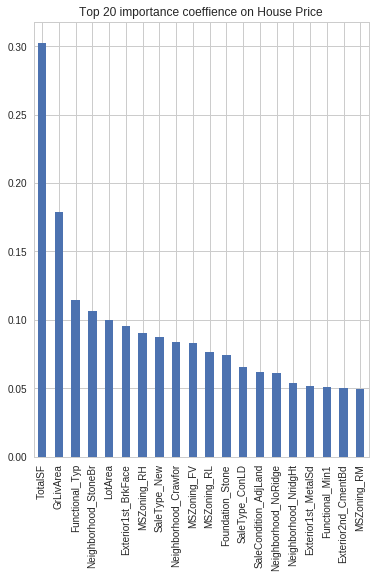

In [71]:
coef = pd.Series(model_ridge.coef_, index=X_train.columns)
imp_coef = coef.sort_values(ascending=False).head(20)

plt.title('Top 20 importance coeffience on House Price')
imp_coef.plot(kind = 'bar', figsize=(6, 8))
